# 🤖 03 - Pelatihan Model BPNN untuk Prediksi Harga Saham ANTM

Notebook ini berisi proses pelatihan model Backpropagation Neural Network (BPNN)  
menggunakan dataset multivariat yang telah diflatten dari hasil sliding window.

## 📂 Load Dataset Flattened (X_flat, y)

In [1]:
import numpy as np

# Load dari file windowed
data = np.load('../data/processed/windowed_antm.npz')
X_flat = data['X_flat']
y = data['y']

print(f"X_flat shape: {X_flat.shape}")
print(f"y shape: {y.shape}")

X_flat shape: (1199, 28)
y shape: (1199, 1)


## ✂️ Split Data ke Train dan Test (80:20)

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.2, shuffle=False
)

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}")

Train: (959, 28), (959, 1)
Test:  (240, 28), (240, 1)


## 🧠 Definisi Arsitektur Model BPNN

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,081 (23.75 KB)

 Trainable params: 6,081 (23.75 KB)

 Non-trainable params: 0 (0.00 B)

## 🏋️ Pelatihan Model BPNN

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028 - mae: 0.0390 - val_loss: 0.0015 - val_mae: 0.0337
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - mae: 0.0250 - val_loss: 0.0023 - val_mae: 0.0443
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mae: 0.0245 - val_loss: 4.7057e-04 - val_mae: 0.0173
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4585e-04 - mae: 0.0206 - val_loss: 0.0019 - val_mae: 0.0403
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5811e-04 - mae: 0.0212 - val_loss: 0.0011 - val_mae: 0.0299
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4100e-04 - mae: 0.0207 - val_loss: 3.4094e-04 - val_mae: 0.0140
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8211e-04 - mae: 0.0186 - val_loss: 3.3749e-04 - val_mae: 0.0142
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6208e-04 - mae: 0.0185 - val_loss: 0.0030 - val_mae: 0.0510
Epoch 9/100
30/30 ━━━━━━━━━━━━━━

## 📏 Evaluasi Model BPNN
Evaluasi dilakukan terhadap data uji dengan tiga metrik utama:
- MAE (Mean Absolute Error)
- MSE (Mean Squared Error)
- RMSE (Root Mean Squared Error)

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prediksi terhadap data uji
y_pred = model.predict(X_test)

# Hitung metrik evaluasi
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"📊 MAE  = {mae:.6f}")
print(f"📊 MSE  = {mse:.6f}")
print(f"📊 RMSE = {rmse:.6f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
📊 MAE  = 0.014190
📊 MSE  = 0.000337
📊 RMSE = 0.018371


In [9]:
# Simpan model BPNN (ANTM + Eksternal)
model.save("../models/bpnn_antm_external.keras")
print("✅ Model BPNN (ANTM + Eksternal) berhasil disimpan dalam folder models/")

✅ Model BPNN (ANTM + Eksternal) berhasil disimpan dalam folder models/


## 📉 Visualisasi Prediksi vs Aktual (BPNN)

Grafik berikut menunjukkan perbandingan antara nilai aktual dan hasil prediksi model BPNN terhadap harga saham ANTM.

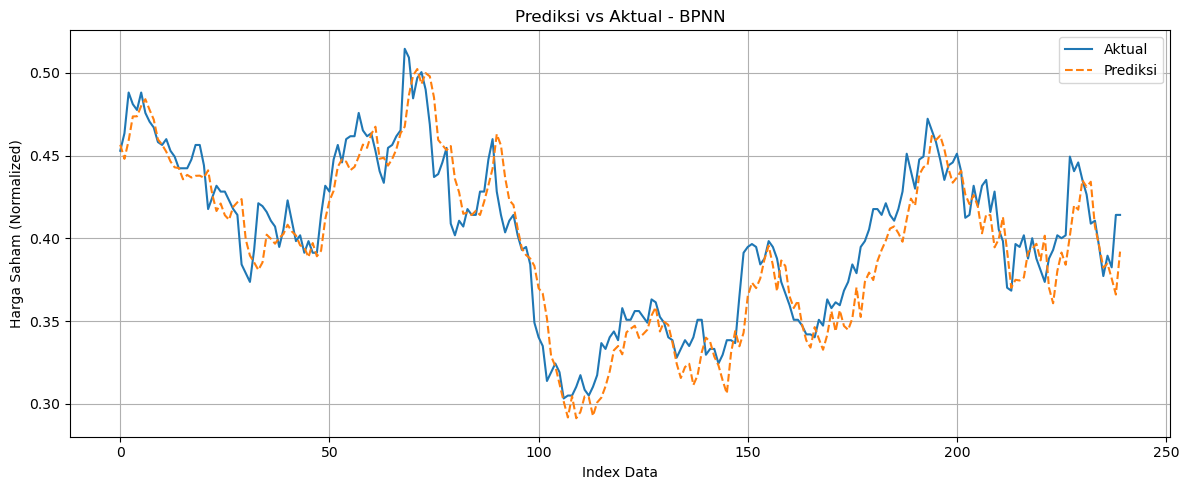

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Aktual')
plt.plot(y_pred, label='Prediksi', linestyle='--')
plt.title('Prediksi vs Aktual - BPNN')
plt.xlabel('Index Data')
plt.ylabel('Harga Saham (Normalized)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 📈 Grafik Loss Training dan Validation - BPNN
Menampilkan kurva loss untuk training dan validasi selama proses pelatihan.

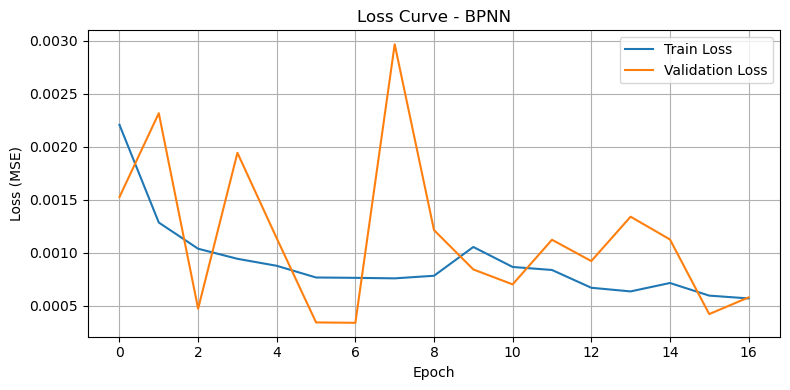

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve - BPNN')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()